<a href="https://colab.research.google.com/github/mxfaqih/crosswalkseg/blob/main/CrosswalkSegV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================
# 1. Setup & Mount Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

# Path dataset
DATASET_DIR = "/content/drive/MyDrive/CrosswalkSeg/dataset"

Mounted at /content/drive
CUDA available: True
GPU: Tesla T4


In [11]:
# =========================
# 2. Import Library
# =========================
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import models

# reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# =========================
# 3. Dataset Loader
# =========================
class CrosswalkDataset(Dataset):
    def __init__(self, root_dir, img_size=512, aug=True):
        """
        root_dir: path ke dataset, misal ".../realdata/cloudy"
        images: *.jpg
        masks : *_mask.png
        """
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.fnames = sorted(os.listdir(self.img_dir))  # asumsikan gambar .jpg
        self.img_size = img_size
        self.aug = aug

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img_path = os.path.join(self.img_dir, fname)

        # mask pakai aturan "_mask.png" (dengan fallback ".PNG")
        base, _ = os.path.splitext(fname)
        candidates = [base + "_mask.png", base + "_mask.PNG"]
        mask_path = None
        for cand in candidates:
            p = os.path.join(self.mask_dir, cand)
            if os.path.exists(p):
                mask_path = p
                break
        if mask_path is None:
            raise FileNotFoundError(f"Mask untuk {fname} tidak ditemukan di {self.mask_dir} (harap pastikan *_mask.png).")

        # load
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # resize (opsional: bisa 512x512, atau tetap 640x360)
        img = TF.resize(img, (self.img_size, self.img_size))
        mask = TF.resize(mask, (self.img_size, self.img_size), interpolation=TF.InterpolationMode.NEAREST)

        # augment (flip)
        if self.aug and random.random() < 0.5:
            img = TF.hflip(img); mask = TF.hflip(mask)

        # to tensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # binerkan

        # normalize imagenet
        img = TF.normalize(img, [0.485,0.456,0.406], [0.229,0.224,0.225])
        return img, mask


In [13]:
# =========================
# 4. Model: DeepLabV3+ with ConvNeXt backbone
# =========================
class ConvNeXtBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        m = models.convnext_tiny(weights="IMAGENET1K_V1" if pretrained else None)
        self.stage1 = nn.Sequential(*list(m.features.children())[0:2]) # stride 4
        self.stage2 = nn.Sequential(*list(m.features.children())[2:4]) # stride 8
        self.stage3 = nn.Sequential(*list(m.features.children())[4:6]) # stride 16
        self.stage4 = nn.Sequential(*list(m.features.children())[6:8]) # stride 32
        self.out_channels_low, self.out_channels_high = 96, 768

    def forward(self, x):
        x = self.stage1(x); low = x
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        return low, x

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.b1 = nn.Conv2d(in_ch, out_ch, 1, dilation=1)
        self.b2 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6)
        self.b3 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.b4 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.gap = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_ch, out_ch, 1))
        self.proj = nn.Conv2d(out_ch*5, out_ch, 1)

    def forward(self, x):
        y1 = self.b1(x); y2 = self.b2(x); y3 = self.b3(x); y4 = self.b4(x)
        y5 = self.gap(x)
        y5 = nn.functional.interpolate(y5, size=y4.shape[2:], mode="bilinear", align_corners=False)
        y = torch.cat([y1,y2,y3,y4,y5], dim=1)
        return self.proj(y)

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.backbone = ConvNeXtBackbone(pretrained=True)
        self.aspp = ASPP(768, 256)
        self.low_proj = nn.Conv2d(96, 48, 1)
        self.decoder = nn.Sequential(
            nn.Conv2d(256+48, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        H, W = x.shape[2:]
        low, high = self.backbone(x)
        y = self.aspp(high)
        y = nn.functional.interpolate(y, size=low.shape[2:], mode="bilinear", align_corners=False)
        low = self.low_proj(low)
        y = torch.cat([y, low], dim=1)
        y = self.decoder(y)
        y = nn.functional.interpolate(y, size=(H, W), mode="bilinear", align_corners=False)
        return self.classifier(y)

In [14]:
# =========================
# 5. Loss & Metrics
# =========================
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6): super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        inter = (probs*targets).sum(dim=(2,3))
        union = probs.sum(dim=(2,3))+targets.sum(dim=(2,3))
        dice = (2*inter+self.eps)/(union+self.eps)
        return 1-dice.mean()

def iou_score(logits, targets, thr=0.5):
    preds = (torch.sigmoid(logits)>thr).float()
    inter = (preds*targets).sum(dim=(2,3))
    union = (preds+targets-preds*targets).sum(dim=(2,3))
    return ((inter+1e-6)/(union+1e-6)).mean().item()


In [15]:
# =========================
# 6. Training Loop
# =========================
def train_model(train_loader, val_loader, epochs=20, lr=1e-4):
    model = DeepLabV3Plus(num_classes=1).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss()

    for epoch in range(epochs):
        model.train(); total_loss=0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            opt.zero_grad()
            out = model(imgs)
            loss = 0.5*bce(out,masks)+0.5*dice(out,masks)
            loss.backward(); opt.step()
            total_loss+=loss.item()*imgs.size(0)
        avg_loss=total_loss/len(train_loader.dataset)

        # val
        model.eval(); val_iou=[]
        with torch.no_grad():
            for imgs,masks in val_loader:
                imgs,masks=imgs.to(device),masks.to(device)
                out=model(imgs)
                val_iou.append(iou_score(out,masks))
        print(f"Epoch {epoch+1}/{epochs} Loss {avg_loss:.4f} Val IoU {np.mean(val_iou):.4f}")
    return model


In [16]:
# =========================
# 7. DataLoader untuk kondisi tertentu
# =========================
# contoh: gabung semua kondisi realdata untuk training
train_paths = [
    os.path.join(DATASET_DIR,"realdata","sunny"),
    os.path.join(DATASET_DIR,"realdata","cloudy"),
    os.path.join(DATASET_DIR,"realdata","rainy")
]
val_path = os.path.join(DATASET_DIR,"realdata","night")  # contoh pakai night sebagai val

train_ds = torch.utils.data.ConcatDataset([CrosswalkDataset(p, img_size=512, aug=True) for p in train_paths])
val_ds = CrosswalkDataset(val_path, img_size=512, aug=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Train samples: 240 Val samples: 60


In [17]:
# =========================
# 8. Train
# =========================
model = train_model(train_loader, val_loader, epochs=30, lr=1e-4)

Epoch 1/30 Loss 0.2786 Val IoU 0.8226
Epoch 2/30 Loss 0.0825 Val IoU 0.8828
Epoch 3/30 Loss 0.0617 Val IoU 0.8820
Epoch 4/30 Loss 0.0511 Val IoU 0.8809
Epoch 5/30 Loss 0.0431 Val IoU 0.8344
Epoch 6/30 Loss 0.0444 Val IoU 0.8938
Epoch 7/30 Loss 0.0329 Val IoU 0.8786
Epoch 8/30 Loss 0.0297 Val IoU 0.8906
Epoch 9/30 Loss 0.0286 Val IoU 0.8846
Epoch 10/30 Loss 0.0263 Val IoU 0.8517
Epoch 11/30 Loss 0.0259 Val IoU 0.8824
Epoch 12/30 Loss 0.0234 Val IoU 0.8126
Epoch 13/30 Loss 0.0224 Val IoU 0.8719
Epoch 14/30 Loss 0.0210 Val IoU 0.8895
Epoch 15/30 Loss 0.0227 Val IoU 0.8752
Epoch 16/30 Loss 0.0337 Val IoU 0.8955
Epoch 17/30 Loss 0.0252 Val IoU 0.8910
Epoch 18/30 Loss 0.0239 Val IoU 0.8867
Epoch 19/30 Loss 0.0210 Val IoU 0.8963
Epoch 20/30 Loss 0.0193 Val IoU 0.8778
Epoch 21/30 Loss 0.0168 Val IoU 0.8825
Epoch 22/30 Loss 0.0171 Val IoU 0.8801
Epoch 23/30 Loss 0.0166 Val IoU 0.8871
Epoch 24/30 Loss 0.0167 Val IoU 0.8710
Epoch 25/30 Loss 0.0170 Val IoU 0.9103
Epoch 26/30 Loss 0.0155 Val IoU 0.

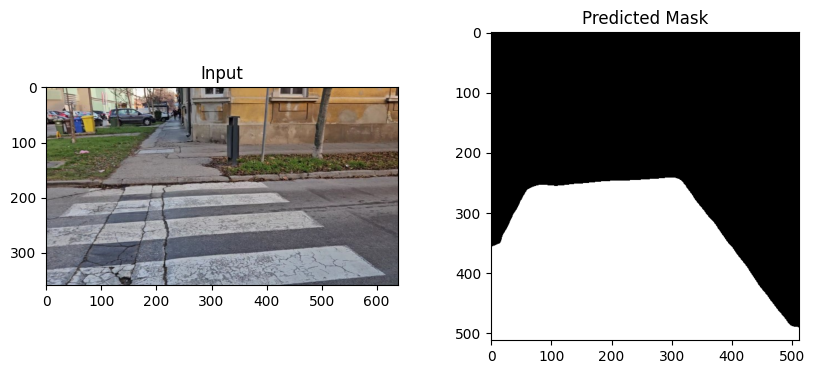

In [18]:
# =========================
# 9. Inference Demo
# =========================
import matplotlib.pyplot as plt

def infer_and_show(model, img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_resized = TF.resize(img,(512,512))
    t = TF.to_tensor(img_resized)
    t = TF.normalize(t,[0.485,0.456,0.406],[0.229,0.224,0.225]).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        prob = torch.sigmoid(out)[0,0].cpu().numpy()
    mask_pred = (prob>0.5).astype(np.uint8)*255

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Input")
    plt.subplot(1,2,2); plt.imshow(mask_pred,cmap="gray"); plt.title("Predicted Mask")
    plt.show()

# contoh prediksi
test_img = os.path.join(DATASET_DIR,"realdata","sunny","images", os.listdir(os.path.join(DATASET_DIR,"realdata","sunny","images"))[0])
infer_and_show(model, test_img)